In [95]:
# Import data
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
df = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='factors')
df = df.set_index('Date')
df = df.drop(columns=['RF'])
df.tail()



,Mkt-RF,SMB,HML
Date,,,
2022-04-30,-0.0946,-0.0141,0.0619
2022-05-31,-0.0034,-0.0185,0.0841
2022-06-30,-0.0843,0.0209,-0.0597
2022-07-31,0.0957,0.0281,-0.0410
2022-08-31,-0.0378,0.0139,0.0031


#### 2 The Factors
##### 1. Calculate their univariate performance statistics: mean, volatility, Sharpe, and VaR

In [96]:
def portfolio_stats(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol
    
    # VaR
    var = data.quantile(0.05)

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio, var], 
        index = ['Mean', 'Volatility', 'Sharpe', 'VaR (0.05)']), 4)

print("Beginning-1980")
pre1980 = df.copy().loc[:'1980']
display(portfolio_stats(pre1980))

print("1981-2001")
midPortfolio = df.copy().loc['1981':'2001']
display(portfolio_stats(midPortfolio))

print("2002-End")
presentPortfolio = df.copy().loc['2002':]
display(portfolio_stats(presentPortfolio))

Beginning-1980


,Mkt-RF,SMB,HML
Mean,0.0811,0.0340,0.0495
Volatility,0.2051,0.1146,0.1338
Sharpe,0.3957,0.2966,0.3697
VaR (0.05),-0.0840,-0.0434,-0.0429


1981-2001


,Mkt-RF,SMB,HML
Mean,0.0773,-0.0009,0.0637
Volatility,0.1574,0.1184,0.1113
Sharpe,0.4908,-0.0074,0.5727
VaR (0.05),-0.0645,-0.0466,-0.0418


2002-End


,Mkt-RF,SMB,HML
Mean,0.0833,0.0196,0.0017
Volatility,0.1540,0.0858,0.1045
Sharpe,0.5409,0.2288,0.0161
VaR (0.05),-0.0788,-0.0378,-0.0410


##### 2.2 Based on the factors, answer the following:
a. Does each factor have a premium (positive expected excess return) in each subsample?
<br/>b. Does the premium to the size factor get smaller after 1980?
<br/>c. Does the premium to the value factor get smaller during the 1990s?
<br/>d. How have the factors performed since the time of the case (2002-Present)?

a) No, SMB (the size factor) had a negative expected return in the period 1981-2001.
<br/>
b) Recalling that premium is the expected excess return, we can see that the size factor does get smaller after 1980, and in fact goes negative, but then returns positive after 2002.
<br/>
c) Yes, we can see that the Mean of HML (the value factor) drops from 0.0637 to 0.0017 after 2002
<br/>
d) We see that the market has improved premium post-2002, as has the size factor, but the value factor premium has decreased. The Sharpe ratios have also varied significantly for the size and value factors, increasing for SMB and decreasing for HML. However, the market outperformed both post-2002.

#### 2.3 Report the correlation matrix accross the three factors. Does the construction method succeed in keeping the correlations small? Does it achieve this in each subsample?

Whole Sample Correlations


<AxesSubplot: >

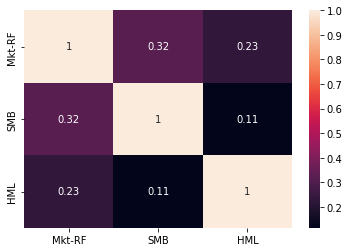

In [97]:
corrmat = df.corr()
#ignore self-correlation
print("Whole Sample Correlations")
display(sns.heatmap(corrmat,annot=True))

Pre-1980 Correlations


<AxesSubplot: >

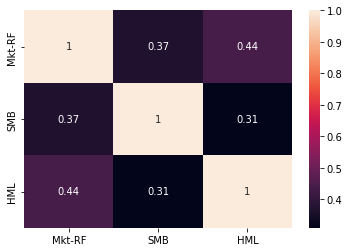

In [98]:
print("Pre-1980 Correlations")
display(sns.heatmap(pre1980.corr(),annot=True))

1981-2001 Correlations


<AxesSubplot: >

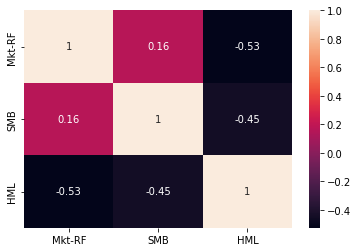

In [99]:
print("1981-2001 Correlations")
display(sns.heatmap(midPortfolio.corr(),annot=True))

Post-2001 Correlations


<AxesSubplot: >

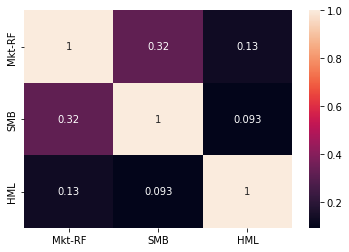

In [100]:
print("Post-2001 Correlations")
display(sns.heatmap(presentPortfolio.corr(),annot=True))

The correlations do appear to be relatively small for the sample, and the construction method is in fact most successful at keeping the correlations small in the post-2001 data. The largest correlation we see is a negative correlation of -0.53 between the value factor and the market between 1981 and 2001.

#### 2.4 Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

<AxesSubplot: title={'center': 'Full-sample'}, xlabel='Date'>

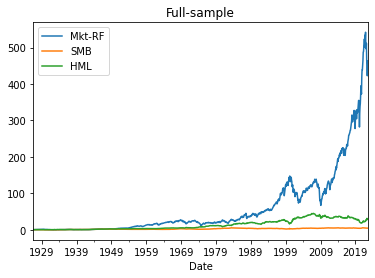

In [101]:
((df + 1).cumprod() - 1).plot(title = "Full-sample")

<AxesSubplot: title={'center': 'Full-sample'}, xlabel='Date'>

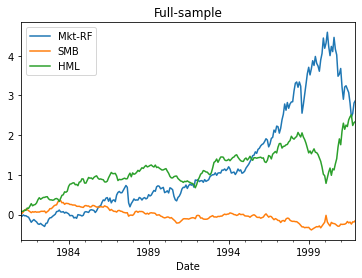

In [102]:
((midPortfolio + 1).cumprod() - 1).plot(title = "Full-sample")

<AxesSubplot: title={'center': 'Full-sample'}, xlabel='Date'>

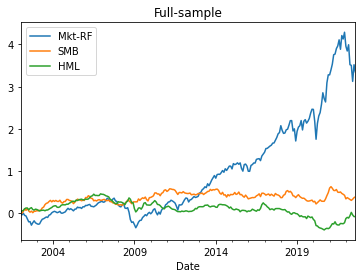

In [103]:
((presentPortfolio + 1).cumprod() - 1).plot(title = "Full-sample")

#### 2.5 Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

No, in 1981-2001 the size factor in fact had a negative premium, and so all three factors were not valuable during this time. Additionally, post-2001, though all three factors had postive mean returns, both the size and value factors' means were significantly smaller than the market. The effects of this are made very obvious when looking at the cumulative returns of the three factors over this period. However, the factors may still provide some value to DFA in their small correlations to the market.

### 3 CAPM
#### 1. Summary Stats: Calculate the annualized univariate statistics from 2.1. Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities?

In [111]:
df = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='factors')
df = df.set_index('Date')
riskFreeRate = df.drop(columns=['SMB', 'HML']).loc['1981':]

portfolioData = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='portfolios (total returns)')
portfolioData = portfolioData.set_index('Date')
portfolioData = portfolioData.loc['1981':]

portfolioData_excessReturns = portfolioData.sub(riskFreeRate['RF'], axis=0)
display(portfolioData_excessReturns.head())

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054941,-0.014888,0.009909,0.005911,0.021085,-0.059733,-0.010738,-0.012684,0.007626,0.020623,...,-0.077022,-0.044926,-0.012942,-0.005534,0.003924,-0.071746,-0.083592,-0.074265,-0.010037,0.009464
1981-02-28,-0.044745,-0.010535,0.001444,0.009240,0.014398,-0.014473,0.005102,0.017420,0.024361,0.027939,...,0.002600,0.014707,0.034695,0.002673,0.027240,0.021950,0.009415,-0.016450,0.020446,-0.016853
1981-03-31,0.060718,0.082395,0.073568,0.077655,0.061040,0.068082,0.071500,0.066319,0.066325,0.063175,...,0.080443,0.055672,0.073222,0.061934,0.064868,0.017353,0.019940,-0.008875,0.022230,0.069573
1981-04-30,0.018141,0.035914,0.024600,0.036523,0.044090,0.006012,0.024744,0.026586,0.026781,0.029442,...,-0.010849,-0.019081,-0.006016,-0.007801,0.006253,-0.038311,-0.053508,-0.038006,0.010439,-0.040374
1981-05-31,0.038153,0.037824,0.032399,0.013389,0.016837,0.050452,0.010304,0.016889,-0.008609,0.013558,...,0.023970,0.010245,0.007640,-0.000759,0.021978,0.004288,-0.032791,-0.031355,0.026669,-0.005979


In [112]:
uniStats = portfolio_stats(portfolioData_excessReturns)
display(uniStats)

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Mean,0.0105,0.0957,0.0929,0.1200,0.1321,0.0603,0.1006,0.1066,0.1077,0.1181,...,0.0927,0.0945,0.0936,0.0998,0.1120,0.0889,0.0816,0.0811,0.0671,0.0963
Volatility,0.2724,0.2359,0.1972,0.1914,0.2077,0.2457,0.2032,0.1831,0.1792,0.2120,...,0.2036,0.1770,0.1733,0.1733,0.1968,0.1632,0.1549,0.1523,0.1703,0.2058
Sharpe,0.0384,0.4058,0.4711,0.6270,0.6361,0.2453,0.4953,0.5824,0.6012,0.5571,...,0.4551,0.5341,0.5402,0.5756,0.5693,0.5447,0.5271,0.5324,0.3943,0.4681
VaR (0.05),-0.1165,-0.0976,-0.0864,-0.0752,-0.0883,-0.1046,-0.0840,-0.0787,-0.0764,-0.0942,...,-0.0839,-0.0734,-0.0756,-0.0693,-0.0833,-0.0753,-0.0656,-0.0704,-0.0756,-0.0985


<AxesSubplot: title={'center': 'Volatility vs. Mean'}, xlabel='Volatility'>

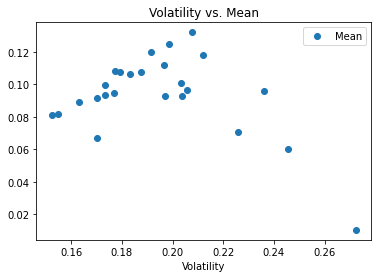

In [113]:
uniStats_pivoted = uniStats.transpose()
uniStats_pivoted.plot(x = 'Volatility', y = 'Mean', style='o', title='Volatility vs. Mean')

<AxesSubplot: title={'center': 'VaR vs. Mean'}, xlabel='VaR (0.05)'>

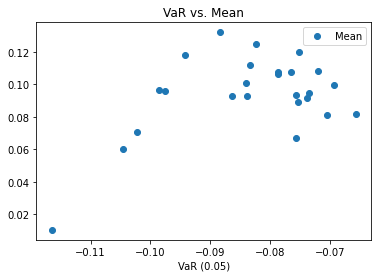

In [114]:
uniStats_pivoted.plot(x = 'VaR (0.05)', y = 'Mean', style='o', title='VaR vs. Mean')

Looking at the scatter plots above, it is fairly clear that there is little to no relationship between the Volatility/VaR and the excess returns of these portfolios.

#### 3.2 CAPM

a) For each of the 25 test portfolios, run the CAPM time-series regression
<br/> b) Report the estimated beta, Treynor Ratio, alpha, and Information Ratio
<br/> c) If CAPM were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

In [119]:
capm_data = portfolioData_excessReturns.join(riskFreeRate)
capm_report = pd.DataFrame(index=portfolioData_excessReturns.columns)
riskFreeRegressor = sm.add_constant(capm_data['Mkt-RF'])
bm_residuals = pd.DataFrame(columns=portfolioData_excessReturns.columns)
t_p_values = pd.DataFrame()

for portf in portfolioData_excessReturns.columns:
    lhs = capm_data[portf]
    res = sm.OLS(lhs, riskFreeRegressor, missing='drop').fit()
    capm_report.loc[portf, 'alpha'] = res.params['const'] * 12
    capm_report.loc[portf, 'beta'] = res.params['Mkt-RF']
    capm_report.loc[portf, 'Information Ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
    capm_report.loc[portf, 'Treynor Ratio'] = 12 * capm_data[portf].mean() / res.params['Mkt-RF']
    bm_residuals[portf] = res.resid
    t_p_values.loc[portf, 't-value'] = res.params['const']
    t_p_values.loc[portf, 't-value'] = res.tvalues['const']
    t_p_values.loc[portf, 'p-value'] = round(res.pvalues['const'], 4)
    
display(capm_report)

,alpha,beta,Information Ratio,Treynor Ratio
SMALL LoBM,-0.098679,1.360046,-0.574986,0.007693
ME1 BM2,0.001824,1.170212,0.012154,0.081807
ME1 BM3,0.009736,1.036480,0.085739,0.089642
ME1 BM4,0.042537,0.965225,0.358477,0.124319
SMALL HiBM,0.052594,0.990693,0.377783,0.133336
ME2 BM1,-0.047520,1.343338,-0.367683,0.044874
ME2 BM2,0.010060,1.128609,0.098400,0.089162
ME2 BM3,0.024815,1.019328,0.271190,0.104593
ME2 BM4,0.030268,0.965384,0.309418,0.111602
ME2 BM5,0.029163,1.108553,0.236327,0.106556


3.2c) If CAPM were true, we would see alphas of all zero's, and as a byproduct the Information Ratio should also be zero. We would expect the Treynor Ratio to equal the mean excess market return.

#### 3.3 Cross-Sectional Estimation

In [121]:
# The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.
y = portfolioData_excessReturns.mean()

# The regressor, (x): the market beta from each of the n = 25 time-series regressions.
X = sm.add_constant(capm_report['beta'])

res = sm.OLS(y,X,missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     8.008
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00950
Time:                        15:23:50   Log-Likelihood:                 123.51
No. Observations:                  25   AIC:                            -243.0
Df Residuals:                      23   BIC:                            -240.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.003      5.362      0.000       0.010       0.023
beta          -0.0082      0.003     -2.830      0.009      -0.014      -0.002
==============================================================================
Omnibus:                        4.531   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                2.975
Skew:                          -0.820   Prob(JB):                        0.226
Kurtosis:                       3.408   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
#3(b) Get the intercept
print(res.params[0] * 12)

#3(c) Report the regression coefficient
print(res.params[1] * 12)

0.19798077049490942
-0.09815760379979302


3.3 a) The R-squared of this regression is 0.258.
<br/>
3.3 b) The intercept is 0.198.
<br/>
3.4 c) The regression coefficient is -0.098

If CAPM were true, we would expect the R-squared to be 1, the intercept to be 0, and the regression coefficient should be the mean excess market return.

#### 3.4 Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

The results support DFA's belief that risks beyond market beta matter, but do not support their emphasis on size and value factors.